In [10]:
import re
import string
import nltk
import contractions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup



In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\likef\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\likef\AppData\Roaming\nltk_data...


True

### Dataset

In [23]:
df = pd.read_csv('data/IMDB-Dataset.csv')
print(len(df))
df = df.drop_duplicates()
print(len(df))
df.head()

50000
49582


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Preprocessing
Clean the data through steps such as: deleting html tags, punctuation, number, symbols, ...

In [7]:
stop = set(stopwords.words('english'))

stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [25]:
def expand_contractions(text):
    return contractions.fix(text)

def preprocess_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, 'html.parser') # remove html tags
    text = soup.get_text()
    text = expand_contractions(text) # expand chatwords and contracts clearing contractions (e.g. don't -> do not, I'm -> I am)
    
    emoji_clean = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text) # add space after full stop
    text = re.sub(r'http\S+', '', text) # remove urls
    text = ''.join([word.lower() for word in text if word not in string.punctuation]) # remove punctuation
    text = ' '.join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) # remove stopwords and lemmatize (e.g. running -> run)
    return text

df['review'] = df['review'].apply(preprocess_text)
df.head()
    

C:\Users\likef\AppData\Local\Temp\ipykernel_12920\3701614496.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser') # remove html tags


,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive


In [26]:
# size of the dictionary
from collections import Counter
words = Counter()
for idx in df.index:
    words.update(df.loc[idx, "review"].split())
print("Size of the dictionary: ", len(words))


Size of the dictionary:  143307


### Analysis the dataset

Text(0.5, 1.0, 'Sentiment Distribution')

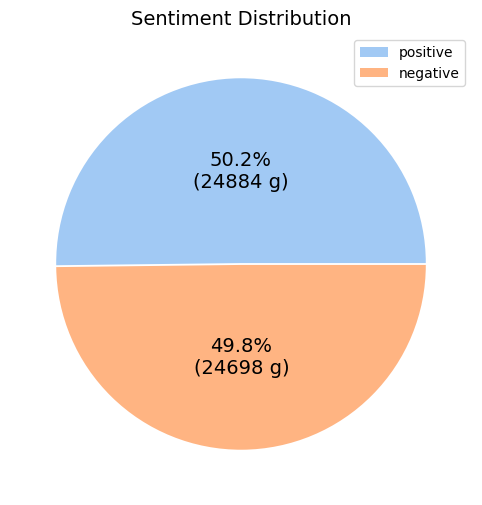

In [14]:
# helper func for plotting pie chart
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return '{:.1f}%\n({:d} g)'.format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['positive', 'negative']

# create the pie chart
pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.005]*2, pctdistance=0.5, colors=[sns.color_palette('pastel')[0], sns.color_palette('pastel')[1]], textprops={'fontsize': 14})
plt.legend(labels=labels, loc='upper right')
plt.title("Sentiment Distribution", fontsize=14)

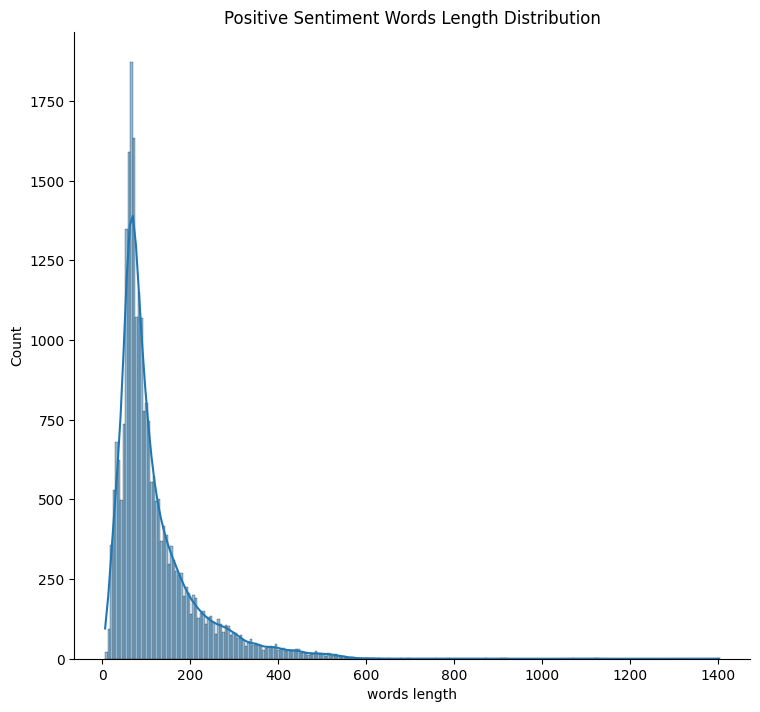

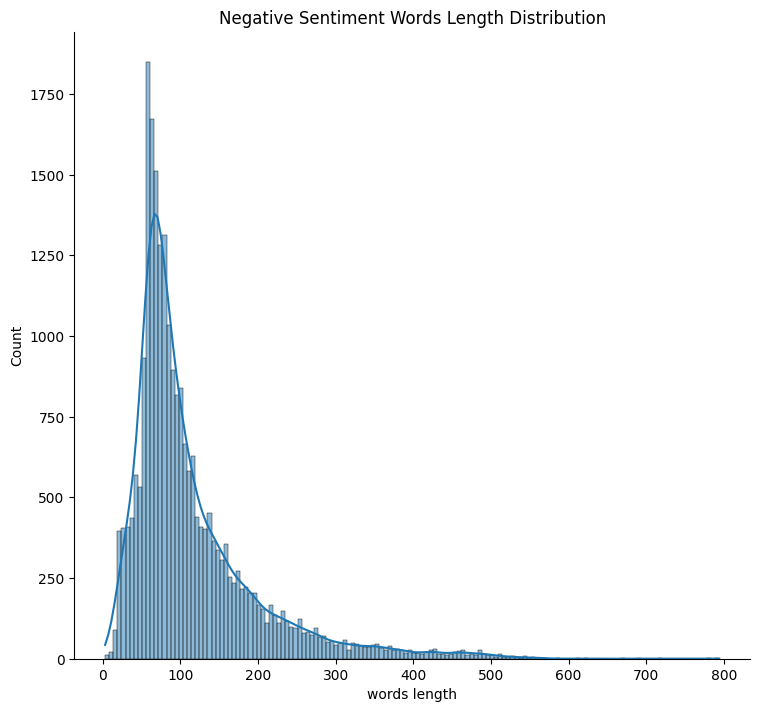

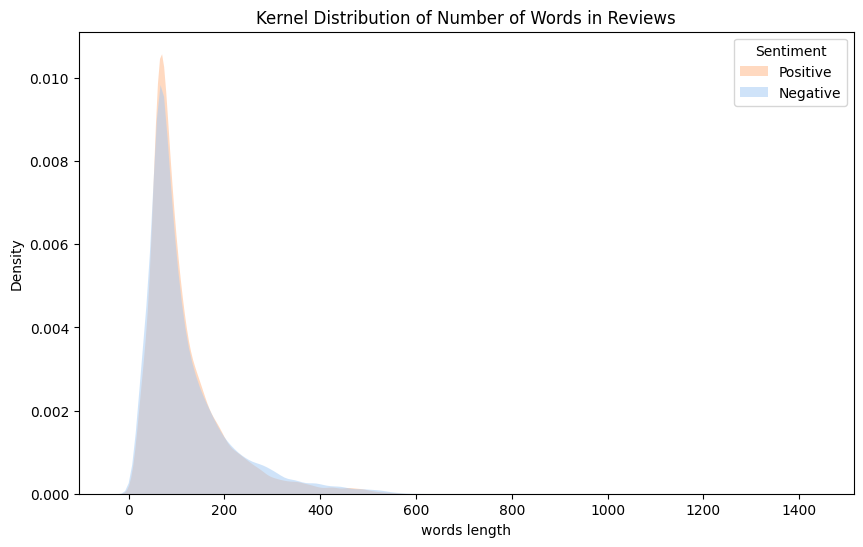

In [16]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(data=df_temp[df_temp['sentiment'] == 'positive'], x='words length', hue='sentiment', kde=True, height=7, aspect=1.1, legend=False).set(title='Positive Sentiment Words Length Distribution')
plt.show(hist_positive)

hist_negative = sns.displot(data=df_temp[df_temp['sentiment'] == 'negative'], x='words length', hue='sentiment', kde=True, height=7, aspect=1.1, legend=False).set(title='Negative Sentiment Words Length Distribution')

plt.figure(figsize=(10, 6))
kernel_distribution_number_words_plot = sns.kdeplot(data=df_temp, x='words length', hue='sentiment', fill=True, common_norm=False, palette='pastel', alpha=.5, linewidth=0).set(title='Kernel Distribution of Number of Words in Reviews')
plt.legend(title='Sentiment', loc='upper right', labels=['Positive', 'Negative'])
plt.show()


### Try to predict with Decision Tree and Random Forest

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [18]:
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(df['review'], y_data, test_size=0.2, random_state=42)

In [19]:
# convert text to vectors
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [21]:
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
print(f'Decision Tree Classifier Accuracy: {accuracy_score(y_test, y_pred)}')

Decision Tree Classifier Accuracy: 0.7139255823333669


In [22]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
print(f'Random Forest Classifier Accuracy: {accuracy_score(y_test, y_pred)}')

Random Forest Classifier Accuracy: 0.8416859937481093
